# Exploring Burnout

Analyze the performance of our Whittle and Adaptive Policies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import json 
import argparse 
import sys
import secrets
from itertools import combinations

In [3]:
from rmab.simulator import run_multi_seed, get_contextual_probabilities
from rmab.whittle_policies import *
from rmab.baseline_policies import *
from rmab.mcts_policies import *
from rmab.utils import get_save_path, delete_duplicate_results, restrict_resources

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
is_jupyter = 'ipykernel' in sys.modules

## Index Policies

In [6]:
import rmab.secret as secret
from rmab.database import *
from rmab.fr_dynamics import *
db_name = secret.database_name 
username = secret.database_username 
password = secret.database_password 
ip_address = secret.ip_address
port = secret.database_port
connection_dict = open_connection(db_name,username,password,ip_address,port)
connection = connection_dict['connection']
cursor = connection_dict['cursor']

query = "SELECT * FROM RESCUES"
all_rescue_data = run_query(cursor,query)

query = ("SELECT * FROM ADDRESSES")
all_addresses = run_query(cursor,query)
len(all_addresses)

address_id_to_latlon = {}
address_id_to_state = {}
for i in all_addresses:
    address_id_to_state[i['id']] = i['state']
    address_id_to_latlon[i['id']] = (i['latitude'],i['longitude'])

user_id_to_latlon = {}
user_id_to_state = {}
user_id_to_start = {}
user_id_to_end = {}

query = ("SELECT * FROM USERS")
user_data = run_query(cursor,query)

for user in user_data:
    if user['address_id'] != None: 
        user_id_to_latlon[user['id']] = address_id_to_latlon[user['address_id']]
        user_id_to_state[user['id']] = address_id_to_state[user['address_id']]
        user_id_to_start[user['id']] = user['created_at']
        user_id_to_end[user['id']] = user['updated_at']


query = (
    "SELECT * "
    "FROM RESCUES "
    "WHERE PUBLISHED_AT <= CURRENT_DATE "
    "AND USER_ID IS NOT NULL "
)

all_user_published = run_query(cursor,query)

query = (
    "SELECT * FROM donor_locations"
)
data = run_query(cursor,query)
donor_location_to_latlon = {}
for i in data:
    donor_location_to_latlon[i['id']] = address_id_to_latlon[i['address_id']]

query = (
    "SELECT * FROM donations"
)
donation_data = run_query(cursor,query)

donation_id_to_latlon = {}
for i in donation_data:
    donation_id_to_latlon[i['id']] = donor_location_to_latlon[i['donor_location_id']]

query = (
    "SELECT USER_ID, PUBLISHED_AT "
    "FROM RESCUES "
    "WHERE PUBLISHED_AT <= CURRENT_DATE "
    "AND USER_ID IS NOT NULL "
)

all_user_published = run_query(cursor,query)

data_by_user = {}
for i in all_user_published:
    user_id = i['user_id']
    published_at = i['published_at']

    if user_id not in data_by_user:
        data_by_user[user_id] = []

    data_by_user[user_id].append(published_at)

num_rescues_to_user_id = {}
for i in data_by_user:
    if len(data_by_user[i]) not in num_rescues_to_user_id:
        num_rescues_to_user_id[len(data_by_user[i])] = []
    num_rescues_to_user_id[len(data_by_user[i])].append(i)

rescue_to_latlon = {}
rescue_to_time = {}
for i in all_rescue_data:
    if i['published_at'] != None and donation_id_to_latlon[i['donation_id']] != None and donation_id_to_latlon[i['donation_id']][0] != None:
        rescue_to_latlon[i['id']] = donation_id_to_latlon[i['donation_id']]
        rescue_to_latlon[i['id']] = (float(rescue_to_latlon[i['id']][0]),float(rescue_to_latlon[i['id']][1]))
        rescue_to_time[i['id']] = i['published_at']



In [7]:
def is_same_week(dt1, dt2):
    return dt1.isocalendar()[:2] == dt2.isocalendar()[:2]


In [8]:
len(data_by_user[502])

60

In [9]:
from collections import Counter

In [10]:
def count_rescues_per_trip(rescue_dates, trip_dates):
    rescue_counts = []  # This will store the count of rescues for each trip
    rescue_pointer = 0  # Pointer to iterate over the rescue dates
    
    # Iterate through each trip date
    for trip_date in trip_dates:
        # Move the rescue pointer to the first date within the 7-day window before the trip
        while rescue_pointer < len(rescue_dates) and rescue_dates[rescue_pointer] < trip_date - timedelta(days=7):
            rescue_pointer += 1
        
        # Count rescues that happened within 7 days before the current trip
        count = 0
        temp_pointer = rescue_pointer
        
        # Count rescues within the week before the trip date
        while temp_pointer < len(rescue_dates) and rescue_dates[temp_pointer] < trip_date:
            count += 1
            temp_pointer += 1
        
        rescue_counts.append(count)
    
    return rescue_counts



In [11]:
def week_start(date):
    """Returns the start of the week for a given date (Monday)."""
    return date - timedelta(days=date.weekday())

def count_rescues_and_trips(relevant_rescues, trip_dates):
    # Group rescues by the start of the week
    weekly_rescues = defaultdict(int)
    weekly_trips = defaultdict(bool)

    # Count the rescues for each week
    for rescue in relevant_rescues:
        week = rescue.isocalendar()[:2]
        weekly_rescues[week] += 1

    # Check if a trip was completed for each week
    for trip in trip_dates:
        week = trip.isocalendar()[:2]
        weekly_trips[week] = True

    # Create a list of results (week, number of rescues, trip completed)
    result = []
    for week in sorted(weekly_rescues.keys()):
        result.append({
            'week_start': week,
            'num_notifications': weekly_rescues[week],
            'trip_completed': weekly_trips.get(week, False)
        })

    return result


In [12]:
from collections import defaultdict


In [27]:
def num_notifications_last_week(user_id):
    user_location = user_id_to_latlon[user_id]
    if user_location[0] == None:
        return [], 0
    user_location = (float(user_location[0]),float(user_location[1]))
    user_end = user_id_to_end[user_id]
    user_start = user_id_to_start[user_id]

    relevant_rescues = [i for i in rescue_to_time if user_start <= rescue_to_time[i] and rescue_to_time[i] <= user_end]
    relevant_rescues = [i for i in relevant_rescues if haversine(user_location[0],user_location[1],rescue_to_latlon[i][0],rescue_to_latlon[i][1]) < 5]
    rescue_dates = [rescue_to_time[i] for i in relevant_rescues]
    
    rescue_dates = sorted(rescue_dates)
    trip_dates = sorted(data_by_user[user_id])
    counts = count_rescues_per_trip(rescue_dates,trip_dates)
    count_2 = count_rescues_and_trips(rescue_dates,trip_dates)
    return counts, count_2

In [51]:
num_trips = 25
rescue_counts = []
total_last_notif = []
total_notif = []
for i in num_rescues_to_user_id[num_trips]:
    if i not in user_id_to_latlon:
        continue 
    a,b = num_notifications_last_week(i)
    if len(a)>0 and len(b) > 4:
        rescue_counts.append(np.mean([i['num_notifications'] for i in b[:4]]))
        total_last_notif.append([i['num_notifications'] for i in b if i['trip_completed']][-1])
        total_notif.append(np.mean([i['num_notifications'] for i in b]))
np.mean(rescue_counts)

87.74056603773585

In [54]:
np.mean(total_last_notif), np.mean(total_notif)

(126.26415094339623, 126.01903714133998)

In [99]:
num_trips = 25
trip_data_by_week = []
for i in num_rescues_to_user_id[num_trips]:
    if i in user_id_to_latlon:
        trip_data_by_week.append(num_notifications_last_week(i)[1])

In [40]:
b

[{'week_start': (2018, 47), 'num_notifications': 1, 'trip_completed': False},
 {'week_start': (2018, 48), 'num_notifications': 7, 'trip_completed': True},
 {'week_start': (2018, 49), 'num_notifications': 5, 'trip_completed': True},
 {'week_start': (2018, 50), 'num_notifications': 15, 'trip_completed': True},
 {'week_start': (2018, 51), 'num_notifications': 15, 'trip_completed': True},
 {'week_start': (2018, 52), 'num_notifications': 10, 'trip_completed': False},
 {'week_start': (2019, 1), 'num_notifications': 27, 'trip_completed': True},
 {'week_start': (2019, 2), 'num_notifications': 24, 'trip_completed': True},
 {'week_start': (2019, 3), 'num_notifications': 32, 'trip_completed': True},
 {'week_start': (2019, 4), 'num_notifications': 34, 'trip_completed': True},
 {'week_start': (2019, 5), 'num_notifications': 28, 'trip_completed': True},
 {'week_start': (2019, 6), 'num_notifications': 35, 'trip_completed': True},
 {'week_start': (2019, 7), 'num_notifications': 28, 'trip_completed': T

In [55]:
b[0]['week_start']

(2018, 10)

In [101]:
num_trips = 25
rescue_counts = []
for i in num_rescues_to_user_id[num_trips]:
    if i in user_id_to_latlon:
        rescue_counts += num_notifications_last_week(i)[0]

In [102]:
intervals = [10,50,100,1000]
num_trips_completed_after_by_notifications = {
    10: [0,0],
    50: [0,0],
    100: [0,0],
    1000: [0,0]
}

In [103]:
def get_interval_num(intervals,num):
    i = 0
    while i<len(intervals):
        if num<intervals[i]:
            return i 
        i+=1
    return len(intervals)

In [104]:
get_interval_num([10,50,100],75)

2

In [105]:
for i in trip_data_by_week:
    for user in trip_data_by_week:
        for idx,row in enumerate(user[:-1]):
            num_notifications = intervals[get_interval_num(intervals,row['num_notifications'])]
            num_trips_completed_after_by_notifications[num_notifications][int(user[idx+1]['trip_completed'])] += 1
        if len(user)>0:        
            num_notifications = intervals[get_interval_num(intervals,user[-1]['num_notifications'])]
            num_trips_completed_after_by_notifications[num_notifications][0] += 1
    

In [106]:
num_trips_completed_after_by_notifications

{10: [14504, 6832],
 50: [58912, 16968],
 100: [26712, 8792],
 1000: [74032, 15792]}

In [107]:
for i in num_trips_completed_after_by_notifications:
    print(i,num_trips_completed_after_by_notifications[i][1]/num_trips_completed_after_by_notifications[i][0])

10 0.47104247104247104
50 0.2880228136882129
100 0.32914046121593293
1000 0.21331316187594554


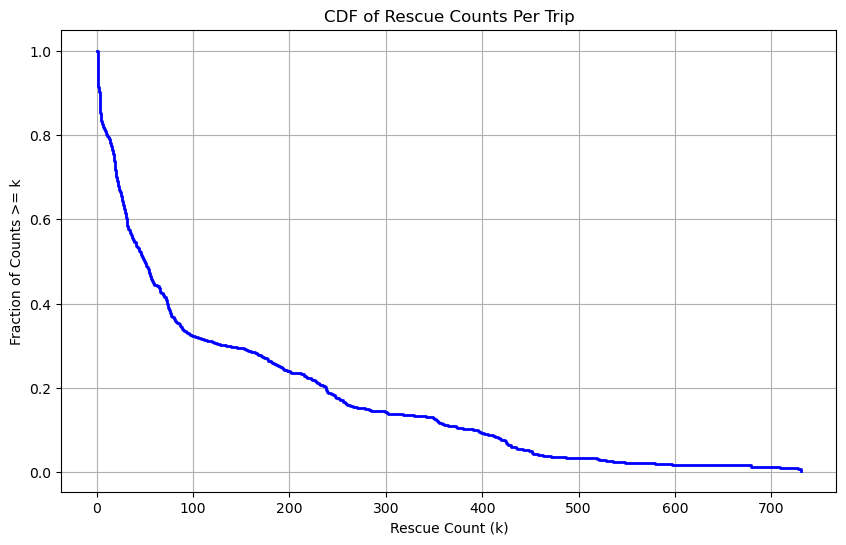

In [108]:
count_freq = Counter(rescue_counts)

# Get unique counts sorted in ascending order
unique_counts = sorted(count_freq.keys())

# Calculate the CDF values for each unique count
total_counts = len(rescue_counts)
cdf_values = []
for k in unique_counts:
    # Calculate the fraction of counts >= k
    fraction = sum(freq for count, freq in count_freq.items() if count >= k) / total_counts
    cdf_values.append(fraction)

# Plotting the CDF
plt.figure(figsize=(10, 6))
plt.step(unique_counts, cdf_values, where='post', color='blue', linewidth=2)
plt.title('CDF of Rescue Counts Per Trip')
plt.xlabel('Rescue Count (k)')
plt.ylabel('Fraction of Counts >= k')
plt.grid(True)
plt.show()



In [109]:
r = 10
1-cdf_values[r]**(1/unique_counts[r])

0.02180560038400925

In [110]:
r = 25
1-(cdf_values[r]/cdf_values[10])**(1/(unique_counts[r]-unique_counts[10]))

0.013419247045985072

In [111]:
r = 100
1-(cdf_values[r]/cdf_values[50])**(1/(unique_counts[r]-unique_counts[50]))

0.008329426972283782

In [112]:
r = len(cdf_values)-1
1-(cdf_values[r]/cdf_values[100])**(1/(unique_counts[r]-unique_counts[100]))

0.007127579383269578

In [ ]:
from collections import Counter

In [ ]:
all_user_ids = list(data_by_user.keys())

In [ ]:
a = num_notifications_last_week(num_rescues_to_user_id[3][0])
np.mean(a[0]),a[1]

In [ ]:
all_notifications = {}
last_notifications = {}
for i in sorted(list(num_rescues_to_user_id.keys()))[2:]:
    temp_all = []
    temp_last = []
    print("on user {}".format(i))
    if i in num_rescues_to_user_id:
        for j in num_rescues_to_user_id[i]: 
            if j in user_id_to_latlon:
                all_counts, last_count = num_notifications_last_week(j)
                if len(all_counts) != 0:
                    temp_all += all_counts 
                    temp_last.append(last_count)
        all_notifications[i] = temp_all 
        last_notifications[i] = temp_last

In [ ]:
json.dump(last_notifications,open("../../results/food_rescue/last_notifications.json","w"))

In [ ]:
json.dump(all_notifications,open("../../results/food_rescue/all_notifications.json","w"))

In [ ]:
d = 1000
np.sum(np.array(last_notifications[3])<d)/(len(np.array(all_notifications[3])))

In [ ]:
num_rescues_to_user_id[4][0]

In [ ]:
probs_increase = [0.05,0.05,0.05,0]
probs_decrease = [0,0.1,0.1,0.1]

all_transitions = np.zeros((4,2,4))
all_transitions[0,1,0] = 1
all_transitions[0,0,1] = probs_increase[0]
all_transitions[0,0,0] = 1-probs_increase[0]

all_transitions[1,1,0] = probs_decrease[1]
all_transitions[1,1,1] = 1-probs_decrease[1]
all_transitions[1,0,2] = probs_increase[1]
all_transitions[1,0,1] = 1-probs_increase[1]

all_transitions[2,1,1] = probs_decrease[2]
all_transitions[2,1,2] = 1-probs_decrease[2]
all_transitions[2,0,3] = probs_increase[2]
all_transitions[2,0,2] = 1-probs_increase[2]

all_transitions[3,1,2] = probs_decrease[1]
all_transitions[3,1,3] = 1-probs_decrease[1]
all_transitions[3,0,3] = 1

In [107]:
policy = greedy_policy
name = "greedy"

rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']
results['ratio'] = simulator.ratio 
print(np.mean(rewards['reward']))

cohort [35  4 66  7]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 3]
Action [1 0 0 1]
State [3 3 3 2]
Action [1 0 0 1]
State [3 3 3 2]
Action [1 0 0 1]
State [3 3 3 2]
Action [1 0 0 1]
State [3 3 3 2]
Action [1 0 0 1]
State [3 3 3 2]
Action [1 0 0 1]
State [3 3 3 2]
Action [1 0 0 1]
State [2 3 3 2]
Action [1 0 0 1]
State [2 3 3 2]
Action [1 0 0 1]
State [2 3 3 2]
Action [1 0 0 1]
State [2 3 3 2]
Action [1 0 0 1]
State [2 3 3 2]
Action [1 0 0 1]
State [2 3 3 2]
Action [1 0 0 1]
State [2 3 3 2]
Action [1 0 0 1]
State [2 3 3 2]
Action [1 0 0 1]
State [1 3 3 2]
Action [1 0 0 1]
State [1 3 3 2]
Action [1 0 0 1]
State [1 3 3 2]
Action [1 0 0 1]
State [1 3 3 2]
Action [1 0 0 1]
State [1 3 3 2]
Action [1 0 0 1]
State [0 3 3 2]
Action [0 1 0 1]
State [0 3 3 2]
Action

In [ ]:
policy = random_policy
name = "random"

rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']
print(np.mean(rewards['reward']))

In [ ]:
if n_arms * volunteers_per_arm <= 4 and 'multi_state' not in prob_distro and 'two_timestep' not in prob_distro:
    policy = q_iteration_policy
    per_epoch_function = q_iteration_custom_epoch()
    name = "optimal"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],per_epoch_function=per_epoch_function,test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']
    print(np.mean(rewards['reward']))

In [ ]:
policy = whittle_activity_policy
name = "whittle_activity"

rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']
print(np.mean(rewards['reward']))

In [108]:
policy = whittle_policy
name = "linear_whittle"

rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
results['{}_reward'.format(name)] = rewards['reward']
results['{}_match'.format(name)] =  rewards['match'] 
results['{}_active'.format(name)] = rewards['active_rate']
results['{}_time'.format(name)] =  rewards['time']
results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']
print(np.mean(rewards['reward']))

cohort [35  4 66  7]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]
[3 3 3 3] [1 0 0 1]
[0.9908226892792735, 0.3593108333511875, 0.268656367145532, 0.4090726047867824]

In [ ]:
simulator.transitions[0,2]

In [ ]:
if n_arms * volunteers_per_arm <= 250 and 'context' in reward_type:
    policy = contextual_whittle_policy
    name = "contextual_whittle"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

In [ ]:
if n_arms * volunteers_per_arm <= 1000:
    policy = shapley_whittle_custom_policy 
    name = "shapley_whittle_custom"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']
    print(np.mean(rewards['reward']))

In [ ]:
simulator.transitions[0,1]

In [ ]:
results['greedy_match'], results['linear_whittle_match'], results['shapley_whittle_custom_match']

In [ ]:
simulator.number_states

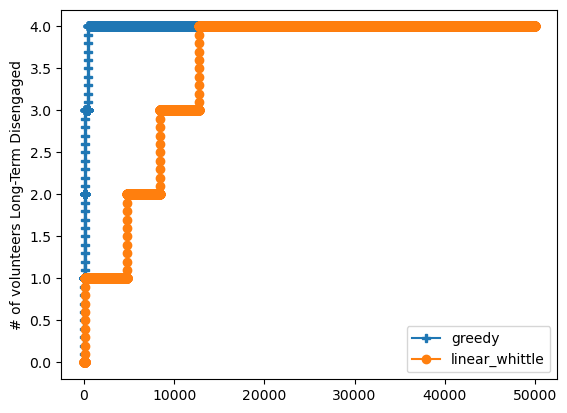

In [13]:
# all_shapes = ['P','o','v','D','s','x','^','<','>']
# for i,m in enumerate(['greedy','linear_whittle']):#,'shapley_whittle_custom']):
#     burned_out_rates = np.array(results['{}_burned_out_rate'.format(m)])[0][0]
#     week_transitions = [i for i in range(len(burned_out_rates)) if np.sum(burned_out_rates[i,:simulator.number_states//2]) == 0]
#     num_fully_burned_out = [burned_out_rates[week_transitions[i]][0] for i in range(len(week_transitions))]
#     plt.ylabel("# of volunteers Long-Term Disengaged")
#     plt.xlabel("Week number")
#     plt.plot(num_fully_burned_out,label=m,marker=all_shapes[i])
#     plt.legend()
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(['greedy','linear_whittle']):#,'shapley_whittle_custom']):
    burned_out_rates = np.array(results['{}_burned_out_rate'.format(m)])[0][0]
    num_fully_burned_out = [burned_out_rates[i][0] for i in range(len(burned_out_rates))]
    plt.ylabel("# of volunteers Long-Term Disengaged")
    plt.plot(moving_average(num_fully_burned_out,n=10),label=m,marker=all_shapes[i])
    plt.legend()

In [ ]:
active_states = [1,2,3]
n_states = 8
all_population_size = 100

initial_prob = np.zeros((all_population_size,n_states))
initial_prob[:,-1] = 1

probs_increase = np.array([0.05,0.05,0.05,0])
probs_decrease = np.array([0,0.25,0.1,0.05])/10
prob_burnout = np.array([0,0.05,0.15,0.05])/10
global_rate = 0.1

all_transitions = np.zeros((all_population_size,n_states,2,n_states))

all_transitions[:,0,1,0] = 1
all_transitions[:,0,0,0] = 1

all_transitions[:,1,1,0] = probs_decrease[1]
all_transitions[:,1,1,1] = 1-probs_decrease[1]
all_transitions[:,1,0,1] = 1

all_transitions[:,2,1,0] = prob_burnout[2]
all_transitions[:,2,1,1] = probs_decrease[2]
all_transitions[:,2,1,2] = 1-probs_decrease[2]-prob_burnout[2]
all_transitions[:,2,0,2] = 1

all_transitions[:,3,1,0] = prob_burnout[3]
all_transitions[:,3,1,2] = probs_decrease[3]
all_transitions[:,3,1,3] = 1-probs_decrease[3]-prob_burnout[3]
all_transitions[:,3,0,3] = 1

all_transitions *= (1-global_rate)
all_transitions[:,0,:,4] = global_rate 
all_transitions[:,1,:,5] = global_rate 
all_transitions[:,2,:,6] = global_rate 
all_transitions[:,3,:,7] = global_rate 

all_transitions[:,4,:,1] = probs_increase[0] 
all_transitions[:,4,:,0] = 1-probs_increase[0] 

all_transitions[:,5,:,2] = probs_increase[1] 
all_transitions[:,5,:,1] = 1-probs_increase[1] 

all_transitions[:,6,:,3] = probs_increase[2] 
all_transitions[:,6,:,2] = 1-probs_increase[2] 

all_transitions[:,7,:,3] = 1

In [ ]:
np.sum(all_transitions[0])

In [12]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


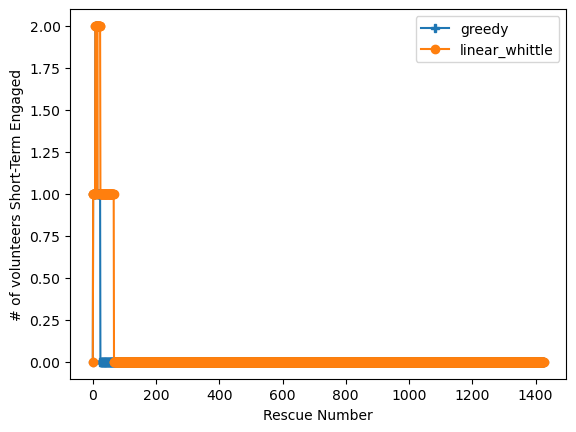

In [12]:
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(['greedy','linear_whittle']):#,'shapley_whittle_custom']):
    burned_out_rates = np.array(results['{}_burned_out_rate'.format(m)])[0][0]
    week_transitions = [i for i in range(len(burned_out_rates)) if np.sum(burned_out_rates[i,:simulator.number_states//2]) == 0]
    num_fully_active = burned_out_rates[week_transitions[0]+1:week_transitions[1]][:,simulator.number_states//4]
    plt.ylabel("# of volunteers Short-Term Engaged")
    plt.xlabel("Rescue Number")
    plt.plot(num_fully_active,label=m,marker=all_shapes[i])
    plt.legend()

In [ ]:
if n_arms * volunteers_per_arm <= 250 and 'context' in reward_type:
    policy = contextual_shapley_policy
    name = "contextual_shapley"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

In [ ]:
if n_arms * volunteers_per_arm <= 250 and 'two_timestep' not in prob_distro:
    policy = whittle_iterative_policy
    name = "iterative_whittle"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']

    print(np.mean(rewards['reward']))

In [ ]:
if n_arms * volunteers_per_arm <= 250 and 'two_timestep' not in prob_distro and 'context' in reward_type:
    policy = non_contextual_whittle_iterative_policy
    name = "non_contextual_iterative_whittle"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']

    print(np.mean(rewards['reward']))


In [ ]:
if n_arms * volunteers_per_arm <= 25 and 'two_timestep' not in prob_distro:
    policy = shapley_whittle_iterative_policy
    name = "shapley_iterative_whittle"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1000)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']
    print(np.mean(rewards['reward']))

In [ ]:
if n_arms * volunteers_per_arm <= 250 and 'two_timestep' not in prob_distro and 'context' in reward_type:
    policy = non_contextual_shapley_whittle_iterative_policy
    name = "non_contextual_shapley_iterative_whittle"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']

    print(np.mean(rewards['reward']))


In [ ]:
if n_arms * volunteers_per_arm <= 25 and 'two_timestep' not in prob_distro:
    policy = mcts_linear_policy
    name = "mcts_linear"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),mcts_test_iterations=400)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']
    print(np.mean(rewards['reward']))


In [ ]:
if n_arms * volunteers_per_arm <= 250 and 'two_timestep' not in prob_distro and 'context' in reward_type:
    policy = non_contextual_mcts_linear_policy
    name = "non_contextual_mcts_linear"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']

    print(np.mean(rewards['reward']))


In [ ]:
if n_arms * volunteers_per_arm <= 25 and 'two_timestep' not in prob_distro:
    policy = mcts_shapley_policy
    name = "mcts_shapley"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),mcts_test_iterations=400)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']

    print(np.mean(rewards['reward']))


In [ ]:
if n_arms * volunteers_per_arm <= 250 and 'two_timestep' not in prob_distro and 'context' in reward_type:
    policy = non_contextual_mcts_shapley_policy
    name = "non_contextual_mcts_shapley"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50))
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    results['{}_burned_out_rate'.format(name)] =  rewards['burned_out_rate']

    print(np.mean(rewards['reward']))


In [ ]:
if n_arms * volunteers_per_arm <= 25 and run_rate_limits:
    policy = mcts_shapley_policy
    name = "mcts_shapley_40"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),mcts_test_iterations=40)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))


In [ ]:
if n_arms * volunteers_per_arm <= 25 and run_rate_limits:
    policy = mcts_shapley_policy
    name = "mcts_shapley_4"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),mcts_test_iterations=4)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))


In [ ]:
if n_arms * volunteers_per_arm <= 50 and run_rate_limits:
    policy = shapley_whittle_iterative_policy
    name = "shapley_iterative_whittle_100"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=100)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

In [ ]:
if n_arms * volunteers_per_arm <= 50 and run_rate_limits:
    policy = shapley_whittle_iterative_policy
    name = "shapley_iterative_whittle_10"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len,shapley_iterations=10)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

In [ ]:
if n_arms * volunteers_per_arm <= 50 and run_rate_limits:
    policy = shapley_whittle_iterative_policy
    name = "shapley_iterative_whittle_1"

    rewards, memory, simulator = run_multi_seed(seed_list,policy,results['parameters'],test_length=episode_len*(n_episodes%50),shapley_iterations=1)
    results['{}_reward'.format(name)] = rewards['reward']
    results['{}_match'.format(name)] =  rewards['match'] 
    results['{}_active'.format(name)] = rewards['active_rate']
    results['{}_time'.format(name)] =  rewards['time']
    print(np.mean(rewards['reward']))

## Write Data

In [ ]:
save_path = get_save_path(out_folder,save_name,seed,use_date=save_with_date)

In [ ]:
delete_duplicate_results(out_folder,"",results)

In [ ]:
json.dump(results,open('../../results/'+save_path,'w'))